<a href="https://colab.research.google.com/github/yashb98/pytorch/blob/main/Animal_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the 'opendatasets' package quietly (without verbose output)
!pip install opendatasets --quiet

# Import the 'opendatasets' library for downloading datasets from online sources like Kaggle
import opendatasets as od

# Download the dataset from the provided Kaggle URL using opendatasets
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yashbishnoi98
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:01<00:00, 371MB/s]


In [2]:
# Import PyTorch core library
import torch

# Import neural network module and Adam optimizer from PyTorch
from torch import nn
from torch.optim import Adam

# Import image transformation utilities from torchvision
from torchvision.transforms import transforms

# Import Dataset and DataLoader utilities for handling data batches
from torch.utils.data import Dataset, DataLoader

# Import LabelEncoder from scikit-learn for encoding categorical labels
from sklearn.preprocessing import LabelEncoder

# Import matplotlib for plotting graphs
import matplotlib.pyplot as plt

# Import PIL for image processing
from PIL import Image

# Import pandas for handling tabular data
import pandas as pd

# Import numpy for numerical operations
import numpy as np

# Import os for interacting with the operating system (e.g., file paths)
import os

# Check if CUDA (GPU) is available; otherwise, use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Print which device will be used for computation
print("Device available: ", device)

Device available:  cuda


In [7]:
# Initialize empty lists to store image file paths and their corresponding labels
image_path = []
labels = []

# Traverse the directory structure under "/content/animal-faces/afhq"
for i in os.listdir("/content/animal-faces/afhq"):
    # For each subfolder in the above path (likely categories or splits)
    for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
        # For each image file inside the label folder
        for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
            # Append the full path to the image file
            image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
            # Append the label (folder name) corresponding to the image
            labels.append(label)

# Create a pandas DataFrame from the image paths and labels, with column names "image_path" and "labels"
df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])

In [9]:
df.head()

,image_path,labels
0,/content/animal-faces/afhq/train/cat/flickr_ca...,cat
1,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
2,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
3,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
4,/content/animal-faces/afhq/train/cat/pixabay_c...,cat


In [12]:
# Print all unique class labels present in the 'labels' column of the dataframe
print(df['labels'].unique())

['cat' 'wild' 'dog']


In [17]:
# Randomly sample 70% of the dataframe rows for training data, using a fixed seed for reproducibility
train = df.sample(frac=0.7, random_state=0)

# Use the remaining 30% of the data as the test set by dropping the training indices from the original dataframe
test = df.drop(train.index)

In [18]:
# From the test set, randomly sample 50% to create a validation set (using a fixed seed for reproducibility)
val = test.sample(frac=0.5, random_state=0)

# Remove the validation samples from the test set, leaving the remaining 50% as the final test set
test = test.drop(val.index)

In [19]:
# Print the number of samples (rows) and features (columns) in the training set
print(train.shape)

# Print the shape of the test set
print(test.shape)

# Print the shape of the validation set
print(val.shape)

(11291, 2)
(2419, 2)
(2420, 2)


In [20]:
# Initialize a LabelEncoder instance to convert categorical labels into numeric form
label_encoder = LabelEncoder()

# Fit the encoder on all unique labels in the dataframe to learn the mapping
label_encoder.fit(df['labels'])


# Define a series of image transformations to be applied on each image during data loading:
transform = transforms.Compose([
    transforms.Resize((128, 128)),         # Resize images to 128x128 pixels
    transforms.ToTensor(),                  # Convert images to PyTorch tensors (scales pixel values to [0,1])
    transforms.ConvertImageDtype(torch.float)  # Convert tensor data type to float (if not already)
])


In [34]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        # Store the dataframe containing image paths and labels
        self.df = df
        # Store the image transformations to be applied on each image (if any)
        self.transform = transform
        # Encode the labels using the previously fitted label encoder,
        # convert to a tensor and move it to the appropriate device (CPU/GPU)
        self.labels = torch.tensor(label_encoder.transform(df['labels'])).to(device)

    def __getitem__(self, index):
        # Retrieve the image file path at the given index from the dataframe
        image_path = self.df.iloc[index, 0]
        # Retrieve the encoded label tensor at the given index
        label = self.labels[index]
        # Open the image file and convert it to RGB format (3 color channels)
        image = Image.open(image_path).convert('RGB')

        # If transformations are provided, apply them to the image
        if self.transform is not None:
            image = self.transform(image).to(device)  # Also move the image tensor to the device

        # Return the transformed image tensor and its corresponding label
        return image, label

    def __len__(self):
        # Return the total number of samples in the dataset
        return self.df.shape[0]

In [35]:
# Create dataset objects for training, testing, and validation sets,
# applying the defined image transformations to each
train_dataset = CustomImageDataset(train, transform=transform)
test_dataset = CustomImageDataset(test, transform=transform)
val_dataset = CustomImageDataset(val, transform=transform)

In [36]:
# Get the total number of samples in the training dataset
train_dataset.__len__()

11291

In [39]:
# Retrieve the first sample (image tensor and label) from the training dataset
train_dataset.__getitem__(0)

(tensor([[[0.3529, 0.3294, 0.3176,  ..., 0.3176, 0.3059, 0.2941],
          [0.3569, 0.3255, 0.3098,  ..., 0.3333, 0.3216, 0.2941],
          [0.3608, 0.3294, 0.3059,  ..., 0.3373, 0.3294, 0.2980],
          ...,
          [0.2510, 0.3529, 0.4314,  ..., 0.3882, 0.3490, 0.3373],
          [0.2353, 0.2941, 0.3725,  ..., 0.4314, 0.3843, 0.3608],
          [0.2314, 0.2510, 0.3059,  ..., 0.4471, 0.4196, 0.4078]],
 
         [[0.5490, 0.5451, 0.5333,  ..., 0.5412, 0.5333, 0.5176],
          [0.5569, 0.5412, 0.5255,  ..., 0.5451, 0.5529, 0.5373],
          [0.5608, 0.5451, 0.5216,  ..., 0.5529, 0.5608, 0.5451],
          ...,
          [0.3137, 0.4157, 0.4941,  ..., 0.4824, 0.4392, 0.4431],
          [0.2941, 0.3569, 0.4392,  ..., 0.5294, 0.4745, 0.4667],
          [0.2902, 0.3176, 0.3765,  ..., 0.5490, 0.5176, 0.5216]],
 
         [[0.2549, 0.2471, 0.2353,  ..., 0.2510, 0.2431, 0.2314],
          [0.2549, 0.2392, 0.2235,  ..., 0.2588, 0.2627, 0.2431],
          [0.2510, 0.2314, 0.2078,  ...,

In [40]:
# Decode the numeric label '0' back to its original string label using the label encoder
label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

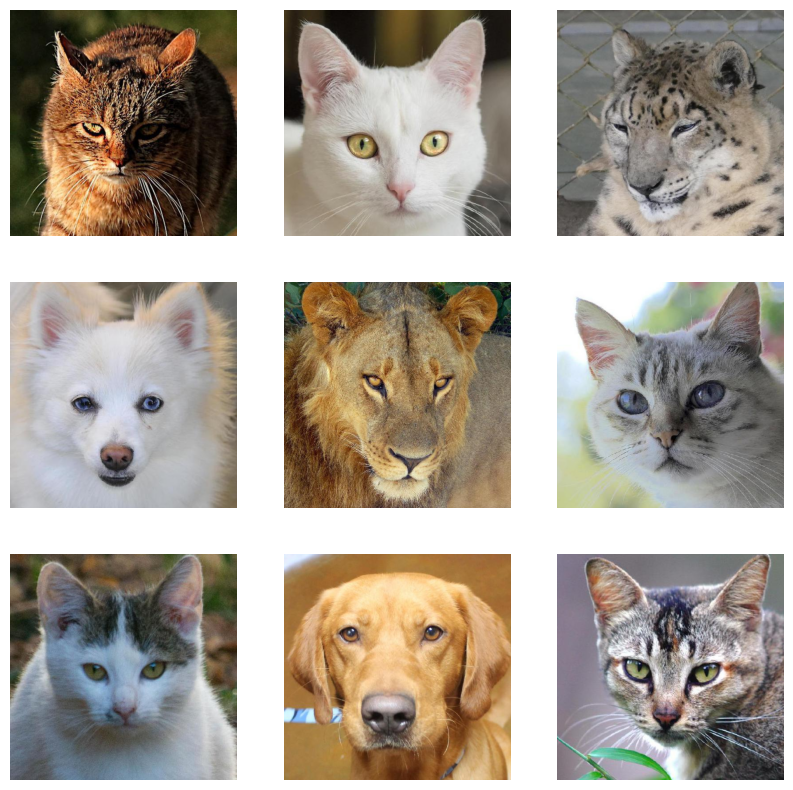

In [42]:
# Define number of rows and columns for the image grid to display
n_rows = 3
n_cols = 3

# Create a matplotlib figure with subplots arranged in a grid (3x3), size 10x10 inches
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Loop through each subplot position (row and column)
for i in range(n_rows):
    for j in range(n_cols):
        # Randomly sample one image path from the dataframe
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
        # Display the image in the subplot
        ax[i, j].imshow(image)
        # Hide the axis ticks and labels for a cleaner look
        ax[i, j].axis('off')

# Show the complete grid of images
plt.show()

In [43]:
# Set the learning rate for the optimizer
LR = 0.0001

# Define the batch size for loading data during training
BATCH_SIZE = 16

# Specify the number of complete passes through the training dataset
EPOCHS = 10

In [44]:
# Create data loaders for training, testing, and validation datasets
# DataLoaders handle batching, shuffling, and parallel loading of data during training

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [50]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional layer: input 3 channels (RGB), output 32 channels, 3x3 kernel, padding=1 to keep spatial size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        # Second convolutional layer: input 32 channels, output 64 channels, 3x3 kernel, padding=1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Third convolutional layer: input 64 channels, output 128 channels, 3x3 kernel, padding=1
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Max pooling layer with kernel size 2x2 and stride 2 to downsample feature maps by half
        self.pooling = nn.MaxPool2d(2, 2)

        # ReLU activation function
        self.relu = nn.ReLU()

        # Flatten layer to convert 3D feature maps to 1D vector for fully connected layers
        self.flatten = nn.Flatten()

        # Fully connected layer: input features 128 * 16 * 16 (after 3 pooling layers), output 128 neurons
        self.linear = nn.Linear(128 * 16 * 16, 128)

        # Output layer: maps 128 features to the number of unique classes in the dataset
        self.output = nn.Linear(128, len(df['labels'].unique()))

    def forward(self, x):
        # Pass input through first conv layer, pooling, then ReLU activation
        x = self.conv1(x)          # Output shape: (batch_size, 32, 128, 128)
        x = self.pooling(x)        # Downsample to (batch_size, 32, 64, 64)
        x = self.relu(x)

        # Pass through second conv layer, pooling, ReLU
        x = self.conv2(x)          # (batch_size, 64, 64, 64)
        x = self.pooling(x)        # (batch_size, 64, 32, 32)
        x = self.relu(x)

        # Pass through third conv layer, pooling, ReLU
        x = self.conv3(x)          # (batch_size, 128, 32, 32)
        x = self.pooling(x)        # (batch_size, 128, 16, 16)
        x = self.relu(x)

        # Flatten the 3D feature maps into 1D vector
        x = self.flatten(x)

        # Fully connected layer with 128 neurons
        x = self.linear(x)

        # Final output layer with logits for each class
        x = self.output(x)

        return x




In [51]:
# Initialize the CNN model and move it to the specified device (GPU if available, else CPU)
model = Net().to(device)

In [52]:
# Print a detailed summary of the model architecture
# Shows output shapes and number of parameters for each layer given an input size of (3, 128, 128)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [53]:
# Define the loss function as CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Initialize the Adam optimizer with the model parameters and specified learning rate
optimizer = Adam(model.parameters(), lr=LR)


In [57]:
# Lists to store loss and accuracy values for plotting later
total_loss_train_plot = []
total_loss_validation_plot = []
total_accuracy_train_plot = []
total_accuracy_validation_plot = []

# Training loop for the specified number of epochs
for epoch in range(EPOCHS):
  total_acc_train = 0      # Accumulator for training accuracy count
  total_loss_train = 0     # Accumulator for training loss
  total_loss_val = 0       # Accumulator for validation loss
  total_acc_val = 0        # Accumulator for validation accuracy count

  # Training phase
  for inputs, labels in train_loader:
    optimizer.zero_grad()  # Clear gradients from previous step

    outputs = model(inputs)               # Forward pass: compute predictions
    train_loss = criterion(outputs, labels)  # Calculate loss for the batch
    total_loss_train += train_loss.item()    # Add batch loss to total training loss

    train_loss.backward()  # Backpropagation to compute gradients
    optimizer.step()       # Update model parameters

    # Calculate number of correct predictions in this batch
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc  # Add to total training accuracy count

  # Validation phase (no gradient calculation for efficiency)
  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)              # Forward pass on validation data
      val_loss = criterion(outputs, labels)  # Calculate validation loss
      total_loss_val += val_loss.item()       # Accumulate validation loss

      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()  # Validation accuracy count
      total_acc_val += val_acc                 # Accumulate validation accuracy

  # Average and scale the losses for plotting
  total_loss_train_plot.append(round(total_loss_train / 1000, 4))
  total_loss_validation_plot.append(round(total_loss_val / 1000, 4))

  # Calculate accuracy percentages for training and validation sets
  total_accuracy_train_plot.append(round((total_acc_train / train_dataset.__len__()) * 100, 4))
  total_accuracy_validation_plot.append(round((total_acc_val / val_dataset.__len__()) * 100, 4))

  # Print epoch results summary
  print(f"""Epoch {epoch + 1}/{EPOCHS},
  Train Loss: {round(total_loss_train / 1000, 4)},
  Train Accuracy: {round((total_acc_train / train_dataset.__len__()) * 100,  4)}%,
  Validation Loss: {round(total_loss_val / 1000, 4)},
  Validation Accuracy: {round((total_acc_val / val_dataset.__len__()) * 100, 4)}%
        """)

Epoch 1/10,
  Train Loss: 0.0971,
  Train Accuracy: 94.9517%,
  Validation Loss: 0.0224,
  Validation Accuracy: 94.9174%     
        
Epoch 2/10,
  Train Loss: 0.0565,
  Train Accuracy: 97.1925%,
  Validation Loss: 0.0169,
  Validation Accuracy: 96.2397%     
        
Epoch 3/10,
  Train Loss: 0.0349,
  Train Accuracy: 98.211%,
  Validation Loss: 0.0257,
  Validation Accuracy: 94.6281%     
        
Epoch 4/10,
  Train Loss: 0.0237,
  Train Accuracy: 98.8132%,
  Validation Loss: 0.0171,
  Validation Accuracy: 96.1157%     
        
Epoch 5/10,
  Train Loss: 0.0162,
  Train Accuracy: 99.2118%,
  Validation Loss: 0.0151,
  Validation Accuracy: 96.8182%     
        
Epoch 6/10,
  Train Loss: 0.0136,
  Train Accuracy: 99.3358%,
  Validation Loss: 0.017,
  Validation Accuracy: 96.8182%     
        
Epoch 7/10,
  Train Loss: 0.0088,
  Train Accuracy: 99.6369%,
  Validation Loss: 0.0171,
  Validation Accuracy: 97.0248%     
        
Epoch 8/10,
  Train Loss: 0.01,
  Train Accuracy: 99.4686

In [58]:
with torch.no_grad():  # Disable gradient calculation for evaluation to save memory and computation
  total_loss_test = 0   # Accumulator for total test loss
  total_acc_test = 0    # Accumulator for total correct predictions on test set

  for inputs, labels in test_loader:
    predictions = model(inputs)  # Forward pass to get model predictions

    # Calculate number of correct predictions in the batch
    acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
    total_acc_test += acc  # Add to total correct predictions count

    # Calculate loss for the batch
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()  # Add batch loss to total test loss

# Print overall accuracy as a percentage on the test set
print(f"Accuracy Score is: {round((total_acc_test / test_dataset.__len__()) * 100, 4)}")

# Print average test loss (scaled down for readability)
print(f"Loss Score is: {round(total_loss_test / 1000, 4)}")

Accuracy Score is: 97.3543
Loss Score is: 0.0162


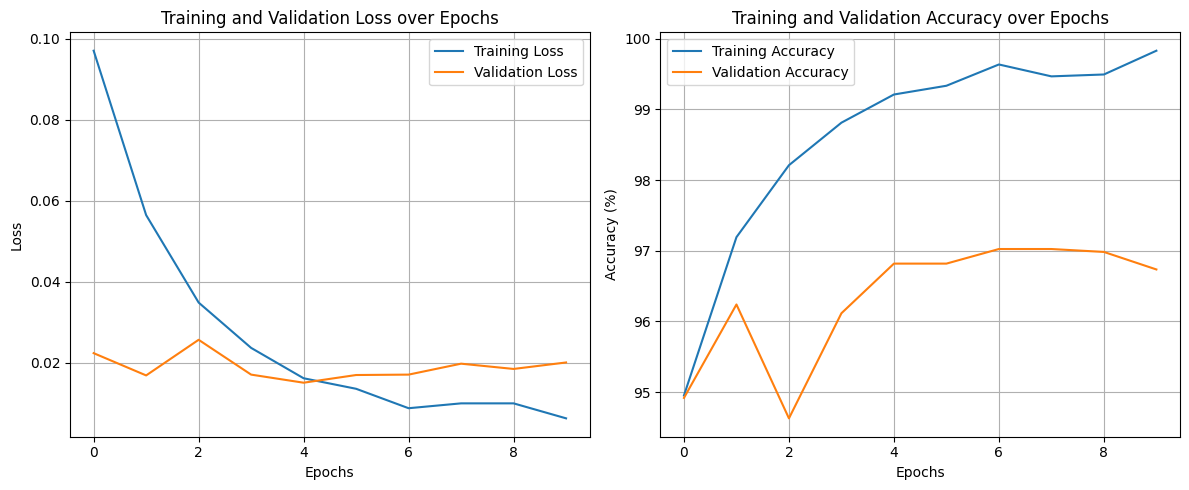

In [59]:
plt.figure(figsize=(12, 5))  # Create a figure with width=12 and height=5 inches

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st plot)
plt.plot(range(EPOCHS), total_loss_train_plot, label='Training Loss')  # Plot training loss over epochs
plt.plot(range(EPOCHS), total_loss_validation_plot, label='Validation Loss')  # Plot validation loss over epochs
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')    # Label for y-axis
plt.title('Training and Validation Loss over Epochs')  # Title of the plot
plt.legend()  # Show legend to differentiate lines
plt.grid(True)  # Enable grid for easier visualization

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd plot)
plt.plot(range(EPOCHS), total_accuracy_train_plot, label='Training Accuracy')  # Plot training accuracy over epochs
plt.plot(range(EPOCHS), total_accuracy_validation_plot, label='Validation Accuracy')  # Plot validation accuracy over epochs
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Accuracy (%)')  # Label for y-axis with percentage symbol
plt.title('Training and Validation Accuracy over Epochs')  # Title of the plot
plt.legend()  # Show legend to differentiate lines
plt.grid(True)  # Enable grid for easier visualization

plt.tight_layout()  # Adjust subplots to fit nicely without overlap
plt.show()  # Display the plot

The model predicts the image is a: dog


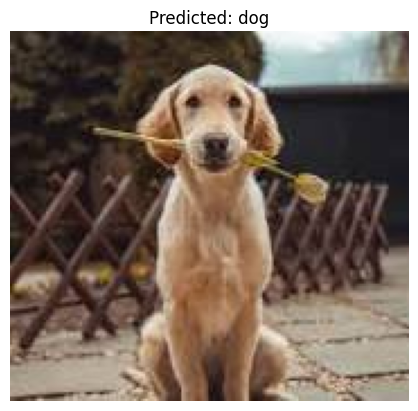

In [62]:
# Function to predict the label of a single image
def predict_image(image_path, model, transform, label_encoder, device):
    # Open the image and apply the transform
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device) # Add batch dimension and send to device

    # Make prediction
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        output = model(image)
        _, predicted_label_index = torch.max(output, 1)

    # Decode the predicted label index
    predicted_label = label_encoder.inverse_transform(predicted_label_index.cpu().numpy())

    return predicted_label[0]

# Path to the image you want to test
test_image_path = "/content/download (1).jpeg"

# Check if the file exists
if os.path.exists(test_image_path):
    # Predict the label for the test image
    predicted_label = predict_image(test_image_path, model, transform, label_encoder, device)

    print(f"The model predicts the image is a: {predicted_label}")

    # Optionally, display the image
    try:
        img = Image.open(test_image_path)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")

else:
    print(f"Error: The image file was not found at {test_image_path}")